In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')
import numpy as np
import pandas as pd
import tqdm
import glob
import os

pd.options.display.max_rows = 99
pd.options.display.max_columns = 60

from nba_api.stats.static import teams, players
import nba_api.stats.endpoints as endp
from nba_api.stats.endpoints import boxscoresummaryv2, leaguegamefinder,\
playbyplayv2, commonplayerinfo, commonallplayers
from nba_api.stats.library.parameters import Season, SeasonType, LeagueIDNullable, SeasonSegment
from nba_api.stats.library.eventmsgtype import EventMsgType
import nba_api.stats.library.playbyplayregex as prex

import altair as alt
from altair_saver import save as alt_save

pd.set_option('max_columns', 120)
pd.set_option('max_rows', 50)

/home/noone/.virtualenvs/env36/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# data

- Curry (https://www.nba.com/player/201939/stephen-curry) - https://www.nba.com/game/por-vs-gsw-0022000092/play-by-play
- Beal (https://www.nba.com/player/203078/bradley-beal) - https://www.nba.com/game/0022000109/ 
- Bryant (https://www.nba.com/player/977/kobe-bryant) -https://www.nba.com/game/uta-vs-lal-0021501228/play-by-play https://www.nba.com/game/0020500591/box-score


- https://www.nba.com/stats/search/player-game/?CF=PTS*gt*60&Season=2020-21&sort=GAME_DATE&dir=1
- https://www.nba.com/stats/search/player-game/?CF=PTS*gt*60&sort=GAME_DATE&dir=1&PlayerID=977&Season=2015-16


- 201939	Stephen Curry

In [2]:
# rrr = endp.shotchartdetail.ShotChartDetail(team_id=1610612744, player_id=201939, context_measure_simple='FGA',
#                                            game_id_nullable='0022000092')
# rrr.get_data_frames()[0]

In [3]:
def get_minute(row):
    per = row['PERIOD']
    tt = row['PCTIMESTRING']
    mm, ss = [int(s) for s in tt.split(':')]
    return per * 12. - (mm + ss / 60)

def get_pbp(game_id):
    pbp = playbyplayv2.PlayByPlayV2(game_id)
    pbp = pbp.get_data_frames()[0]
    pbp['game_minute'] = pbp.apply(get_minute, axis=1)
    return pbp

pbp_curry = get_pbp('0022000092')
print(pbp_curry.shape)
pbp_curry.head()

(519, 35)


,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG,game_minute
0,0022000092,2,12,0,1,8:41 PM,12:00,None,None,None,None,None,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,0,0.000000
1,0022000092,4,10,0,1,8:41 PM,12:00,Jump Ball Wiseman vs. Nurkic: Tip to Jones Jr.,None,None,None,None,4,1630164,James Wiseman,1.610613e+09,Golden State,Warriors,GSW,5,203994,Jusuf Nurkic,1.610613e+09,Portland,Trail Blazers,POR,5,1627884,Derrick Jones Jr.,1.610613e+09,Portland,Trail Blazers,POR,1,0.000000
2,0022000092,7,1,3,1,8:41 PM,11:41,None,None,Nurkic 6' Hook Shot (2 PTS) (McCollum 1 AST),2 - 0,-2,5,203994,Jusuf Nurkic,1.610613e+09,Portland,Trail Blazers,POR,5,203468,CJ McCollum,1.610613e+09,Portland,Trail Blazers,POR,0,0,None,NaN,None,None,None,1,0.316667
3,0022000092,9,7,2,1,8:41 PM,11:41,Wiseman Violation:Defensive Goaltending (M.Dag...,None,None,None,None,4,1630164,James Wiseman,1.610613e+09,Golden State,Warriors,GSW,0,0,None,NaN,None,None,None,1,0,None,NaN,None,None,None,1,0.316667
4,0022000092,10,2,101,1,8:41 PM,11:28,MISS Wiggins 12' Driving Floating Jump Shot,None,None,None,None,4,203952,Andrew Wiggins,1.610613e+09,Golden State,Warriors,GSW,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1,0.533333


In [4]:
# pbp[pbp.EVENTMSGTYPE == EventMsgType.FREE_THROW.value]
# EventMsgType.FREE_THROW

In [5]:
# pbp[pbp.PLAYER1_ID == 201939]

In [6]:
# rr = prex.re_field_goal_made.match(pbp.loc[219].HOMEDESCRIPTION)
# # rr = prex.re_field_goal_missed.match(pbp.loc[47].HOMEDESCRIPTION)
# # rr = prex.re_free_throw_made.match(pbp.loc[22].HOMEDESCRIPTION)
# rr if rr is None else rr.groupdict()

In [7]:
def parse(descr, re_list):
    if descr is None:
        return {}
    for r in re_list:
        m = r.match(descr)
        if m is not None:
            d = m.groupdict()
            
            if r == prex.re_free_throw_miss:
                d['ft'] = 1
                d['val'] = 0
            elif r == prex.re_field_goal_missed:
                d['ft'] = 0
                d['val'] = 0
            elif r == prex.re_free_throw_made:
                d['ft'] = 1
                d['val'] = 1
            elif r == prex.re_field_goal_made:
                d['ft'] = 0
                if '3PT' in d['field_goal_type']:
                    d['val'] = 3
                else:
                    d['val'] = 2 

            return d
                    
    return {}

def parse_description(pbp, team_abbreviation, home):
    re_list = [prex.re_field_goal_made, 
       prex.re_field_goal_missed,
       prex.re_free_throw_made,
       prex.re_free_throw_miss]
    
    pbp['desc'] = pbp.HOMEDESCRIPTION if home else pbp.VISITORDESCRIPTION

    df = pd.concat([pd.DataFrame.from_records(pbp.desc.apply(parse, re_list=re_list)),
               pbp],
              axis=1).query(f'PLAYER1_TEAM_ABBREVIATION == "{team_abbreviation}"')
    df.points = df.points.astype(float)
    return df

df_curry = parse_description(pbp_curry, team_abbreviation="GSW", home=True)
df_curry.head()

,player,distance,field_goal_type,ft,val,points,player_ast,assists,free_throw_type,GAME_ID,EVENTNUM,EVENTMSGTYPE,EVENTMSGACTIONTYPE,PERIOD,WCTIMESTRING,PCTIMESTRING,HOMEDESCRIPTION,NEUTRALDESCRIPTION,VISITORDESCRIPTION,SCORE,SCOREMARGIN,PERSON1TYPE,PLAYER1_ID,PLAYER1_NAME,PLAYER1_TEAM_ID,PLAYER1_TEAM_CITY,PLAYER1_TEAM_NICKNAME,PLAYER1_TEAM_ABBREVIATION,PERSON2TYPE,PLAYER2_ID,PLAYER2_NAME,PLAYER2_TEAM_ID,PLAYER2_TEAM_CITY,PLAYER2_TEAM_NICKNAME,PLAYER2_TEAM_ABBREVIATION,PERSON3TYPE,PLAYER3_ID,PLAYER3_NAME,PLAYER3_TEAM_ID,PLAYER3_TEAM_CITY,PLAYER3_TEAM_NICKNAME,PLAYER3_TEAM_ABBREVIATION,VIDEO_AVAILABLE_FLAG,game_minute,desc
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022000092,4,10,0,1,8:41 PM,12:00,Jump Ball Wiseman vs. Nurkic: Tip to Jones Jr.,None,None,None,None,4,1630164,James Wiseman,1.610613e+09,Golden State,Warriors,GSW,5,203994,Jusuf Nurkic,1.610613e+09,Portland,Trail Blazers,POR,5,1627884,Derrick Jones Jr.,1.610613e+09,Portland,Trail Blazers,POR,1,0.000000,Jump Ball Wiseman vs. Nurkic: Tip to Jones Jr.
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022000092,9,7,2,1,8:41 PM,11:41,Wiseman Violation:Defensive Goaltending (M.Dag...,None,None,None,None,4,1630164,James Wiseman,1.610613e+09,Golden State,Warriors,GSW,0,0,None,NaN,None,None,None,1,0,None,NaN,None,None,None,1,0.316667,Wiseman Violation:Defensive Goaltending (M.Dag...
4,Wiggins,12,Driving Floating Jump Shot,0.0,0.0,NaN,NaN,NaN,NaN,0022000092,10,2,101,1,8:41 PM,11:28,MISS Wiggins 12' Driving Floating Jump Shot,None,None,None,None,4,203952,Andrew Wiggins,1.610613e+09,Golden State,Warriors,GSW,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1,0.533333,MISS Wiggins 12' Driving Floating Jump Shot
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0022000092,11,4,0,1,8:41 PM,11:27,Wiggins REBOUND (Off:1 Def:0),None,None,None,None,4,203952,Andrew Wiggins,1.610613e+09,Golden State,Warriors,GSW,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1,0.550000,Wiggins REBOUND (Off:1 Def:0)
6,Green,17,Pullup Jump Shot,0.0,0.0,NaN,NaN,NaN,NaN,0022000092,12,2,79,1,8:42 PM,11:22,MISS Green 17' Pullup Jump Shot,None,None,None,None,4,203110,Draymond Green,1.610613e+09,Golden State,Warriors,GSW,0,0,None,NaN,None,None,None,0,0,None,NaN,None,None,None,1,0.633333,MISS Green 17' Pullup Jump Shot


In [8]:
def get_event_stats(group, player_name):
    def is_shot():
        return group.val.notna().any()
    
    def is_fgm():
        return group.val.max() >= 2
    
    def is_ft():
        return (group.ft > 0).any()
    
    def is_player():
        return (group.player == player_name).any()
    
    _shot = is_shot()
    _player = is_player()
    _ft = is_ft()
    _fgm = is_fgm()
    _fta = group.ft.sum()
    _player_pts = group.points.max() if _player else np.NaN
    _player_pts = group.val.sum() if _player else np.NaN
    _other_pts = group.points.max() if not _player else np.NaN
    _other_pts = group.val.sum() if not _player else np.NaN
    return pd.Series({'player_fga': int(_shot and (not _ft or _fgm) and _player),
                      'other_fga': int(_shot and (not _ft or _fgm) and (not _player)),
                      'player_ft': int(_fta) if _player else 0,
                      'other_ft': int(_fta) if (not _player) else 0,
                      'val': group.val.sum(),
                      'player_points': _player_pts,
                      'other_points': _other_pts})

def get_line(df, player_name):
    line = (df
#             .groupby(['PERIOD', 'PCTIMESTRING'])
            .groupby(['game_minute'])
            .apply(get_event_stats, player_name=player_name)
           )
    line['player'] = (line.player_ft + line.player_fga) > 0
    line['other'] = (line.other_ft + line.other_fga) > 0
    for c in ['player_points', 'other_points']:
        line[c] = line[c].cumsum().fillna(method='ffill').fillna(0)
        
    line['player_ts'] = (line.player_points.cummax() / (2 * (line.player_fga.cumsum() + 0.44 * line.player_ft.cumsum()))).fillna(0)
    line['other_ts'] = (line.other_points.cummax() / (2 * (line.other_fga.cumsum() + 0.44 * line.other_ft.cumsum()))).fillna(0)
        
    return line

line_curry = get_line(df_curry, player_name='Curry')
line_curry.tail()

,player_fga,other_fga,player_ft,other_ft,val,player_points,other_points,player,other,player_ts,other_ts
game_minute,,,,,,,,,,,
46.900000,1.0,0.0,0.0,0.0,3.0,59.0,73.0,True,False,0.769030,0.583067
47.183333,0.0,0.0,0.0,0.0,0.0,59.0,73.0,False,False,0.769030,0.583067
47.300000,1.0,0.0,0.0,0.0,3.0,62.0,73.0,True,False,0.787602,0.583067
47.450000,0.0,0.0,0.0,0.0,0.0,62.0,73.0,False,False,0.787602,0.583067
47.550000,0.0,1.0,0.0,0.0,2.0,62.0,75.0,False,True,0.787602,0.589623


In [9]:
line_curry.val.sum()

137.0

# Curry

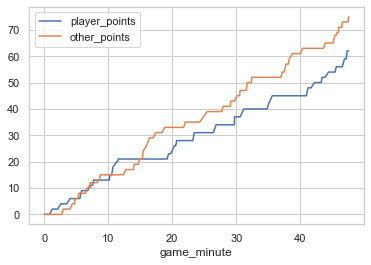

In [10]:
line_curry[['player_points', 'other_points']].plot()

In [13]:
def plot_points(line, player_name):
    rr = (line
          [['player_points', 'other_points']]
          .rename(columns={'player_points': player_name,
                           'other_points': 'Остальные'})
         .reset_index()
         .melt(id_vars='game_minute',  
               value_name='points')
         )
    tt = alt.Chart(rr, height=400, width=600)
    lines = (tt
             .mark_line(color='blue')
             .encode(x=alt.X('game_minute', title='Время', 
                             scale=alt.Scale(domain=(0, 48), clamp=True),
                             axis=alt.Axis(values=[12, 24, 36, 48], grid=True)
                            ), 
                     y=alt.Y('points', title='Набрано очков', 
                            ) ,
                     color=alt.Color('variable', title='')
                      )
            )


    return (
        (lines 

        )
        .configure_legend(labelFontSize=15)
        .configure_axis(
            labelFontSize=15,
            titleFontSize=15
        )
    )

plot_points(line_curry, player_name='Стефен Карри')

alt.Chart(...)

In [14]:
# (line[(
#     (line.curry_fga > 0)
#     | (line.other_fga > 0)
#      )]
#  .loc[4]
# #  .shape
# )

In [15]:
# line[line.curry_fga > 0].loc[3]#.reset_index().groupby('PERIOD').val.count()#.sort_index()#.index.map(lambda i: f{i+2)

In [16]:
print(line_curry.player_fga.sum(), line_curry.other_fga.sum())
print((line_curry.val > 1).sum()) #, (line.val > 1).sum())

31.0 57.0
59


In [17]:
# df[df.PCTIMESTRING == '6:17']

In [18]:
# df[df.PCTIMESTRING == '4:08']

In [19]:
# df[df.free_throw_type == '1 of 1']

,player_fga,other_fga,player_ft,other_ft,val,player_points,other_points,player,other,player_ts,other_ts
game_minute,,,,,,,,,,,
47.55,0.0,1.0,0.0,0.0,2.0,62.0,75.0,False,True,0.787602,0.589623


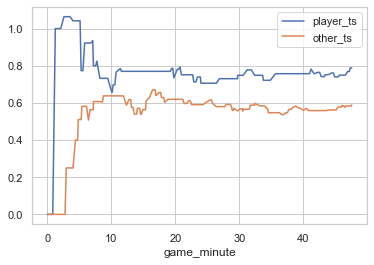

In [20]:
line_curry[['player_ts', 'other_ts']].plot()
line_curry.tail(1)

In [36]:
def plot_ts(line, player_name):
    rr = (line
          [['player_ts', 'other_ts']]
          .rename(columns={'player_ts': player_name,
                           'other_ts': 'Остальные'})
         .reset_index()
         .melt(id_vars='game_minute',  
               value_name='ts')
         )
    tt = alt.Chart(rr, height=400, width=600)
    lines = (tt
             .mark_line(color='blue')
             .encode(x=alt.X('game_minute', title='Время', 
                             scale=alt.Scale(domain=(0, 48), clamp=True),
                             axis=alt.Axis(values=[12, 24, 36, 48], grid=True)
                            ), 
                     y=alt.Y('ts', title='TS%', 
                            ) ,
                     color=alt.Color('variable', title='')
                      )
            )


    return (
        (lines 

        )
        .configure_legend(labelFontSize=15)
        .configure_axis(
            labelFontSize=15,
            titleFontSize=15
        )
    )

plot_ts(line_curry, player_name='Стефен Карри')

alt.Chart(...)

# Beal

In [21]:
pbp_beal = get_pbp('0022000109')

In [22]:
df_beal = parse_description(pbp_beal, team_abbreviation="WAS", home=False)

In [23]:
line_beal = get_line(df_beal, player_name='Beal')

In [24]:
# (line_beal[(
#     (line_beal.player_fga > 0)
# #     | (line_beal.other_fga > 0)
#      )]
#  .loc[3]
# #    .shape
# )

In [25]:
# line_beal.loc[3]

In [26]:
# df_beal[df_beal.PCTIMESTRING == '2:57']

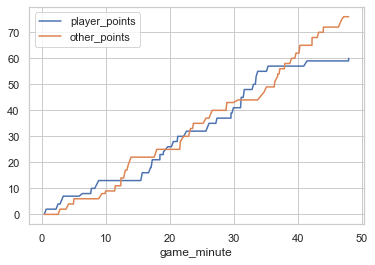

In [27]:
line_beal[['player_points', 'other_points']].plot()

In [28]:
plot_points(line_beal, player_name='Бредли Бил')

alt.Chart(...)

34.0 58.0


,player_fga,other_fga,player_ft,other_ft,val,player_points,other_points,player,other,player_ts,other_ts
game_minute,,,,,,,,,,,
47.933333,0.0,0.0,2.0,0.0,1.0,60.0,76.0,True,False,0.738916,0.568862


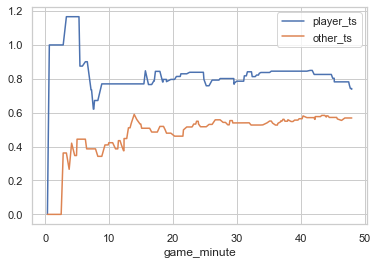

In [29]:
line_beal[['player_ts', 'other_ts']].plot()
print(line_beal.player_fga.sum(), line_beal.other_fga.sum())
line_beal.tail(1)

In [41]:
plot_ts(line_beal, player_name='Бредли Бил')

alt.Chart(...)

# Kobe

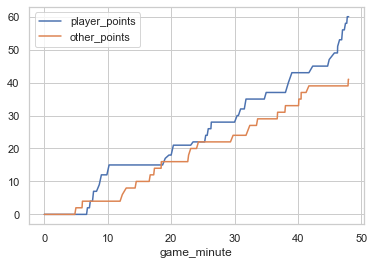

In [30]:
pbp_kobe1 = get_pbp('0021501228')
df_kobe1 = parse_description(pbp_kobe1, team_abbreviation="LAL", home=True)
line_kobe1 = get_line(df_kobe1, player_name='Bryant')
line_kobe1[['player_points', 'other_points']].plot()

In [47]:
plot_points(line_kobe1, player_name='Кобе Брайант')

alt.Chart(...)

50.0 35.0


,player_fga,other_fga,player_ft,other_ft,val,player_points,other_points,player,other,player_ts,other_ts
game_minute,,,,,,,,,,,
47.983333,0.0,0.0,0.0,0.0,0.0,60.0,41.0,False,False,0.542692,0.564427


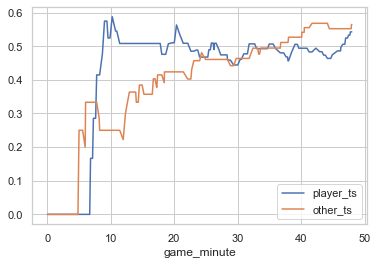

In [32]:
line_kobe1[['player_ts', 'other_ts']].plot()
print(line_kobe1.player_fga.sum(), line_kobe1.other_fga.sum())
line_kobe1.tail(1)

In [46]:
plot_ts(line_kobe1, player_name='Кобе Брайант')

alt.Chart(...)

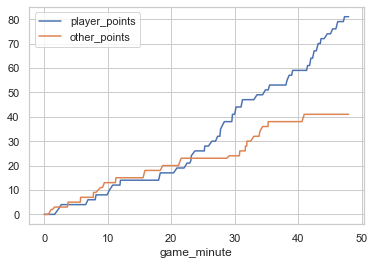

In [33]:
pbp_kobe2 = get_pbp('0020500591')
df_kobe2 = parse_description(pbp_kobe2, team_abbreviation="LAL", home=True)
line_kobe2 = get_line(df_kobe2, player_name='Bryant')
line_kobe2[['player_points', 'other_points']].plot()

In [45]:
plot_points(line_kobe2, player_name='Кобе Брайант')

alt.Chart(...)

46.0 41.0


,player_fga,other_fga,player_ft,other_ft,val,player_points,other_points,player,other,player_ts,other_ts
game_minute,,,,,,,,,,,
47.933333,0.0,0.0,0.0,0.0,0.0,81.0,41.0,False,False,0.739051,0.438784


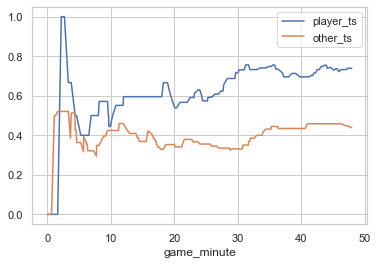

In [35]:
line_kobe2[['player_ts', 'other_ts']].plot()
print(line_kobe2.player_fga.sum(), line_kobe2.other_fga.sum())
line_kobe2.tail(1)

In [44]:
plot_ts(line_kobe2, player_name='Кобе Брайант')

alt.Chart(...)